# Введение

В данной работе будем применять архитектуру Cycle-GAN'а для переноса стилей с датасетов:

1) Клоны, штурмовики(200): 80%-трейн,20%-тест

2) Дарт вейдер(100): 80%-трейн,20%-тест



In [3]:
import os,itertools
import numpy as np
from matplotlib import pylab as plt
from PIL import Image
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import time
import random
from skimage import color

In [4]:
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.determenistic = True

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [7]:
class Mydataset(data.Dataset):
    def __init__(self,root,transform=None):
        imgs=os.listdir(root)
        self.imgs=sorted([os.path.join(root,img) for img in imgs])
        self.transform=transform
        
    def __getitem__(self,index):
        img_path=self.imgs[index]
        image=Image.open(img_path)
        if image.mode != "RGB":
            image = to_rgb(image)
        if self.transform is not None:
            image=self.transform(image)
        return image
    
    def __len__(self):
        return len(self.imgs)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [53]:
trainA_path = "/content/drive/My Drive/Colab Notebooks/vader/train_vader"
trainB_path = "/content/drive/My Drive/Colab Notebooks/clones/train_clones"
testA_path= "/content/drive/My Drive/Colab Notebooks/vader/test_vader"
testB_path="/content/drive/My Drive/Colab Notebooks/clones/test_clones"

In [54]:
transform=transforms.Compose([
    transforms.Resize(int(256*1.12), Image.BICUBIC),
    transforms.RandomCrop((256,256)),
    transforms.RandomChoice(
        [transforms.ColorJitter(0.5,0.5),
         transforms.RandomHorizontalFlip(0.5),
         transforms.RandomGrayscale(p=0.1),
         transforms.RandomRotation(25)]
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test=transforms.Compose([
    transforms.Resize(256, Image.BICUBIC),
    #transforms.RandomCrop((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_A=Mydataset(trainA_path,transform=transform)
train_loader_A=data.DataLoader(train_A,batch_size=1,shuffle=True,num_workers=0)

train_B=Mydataset(trainB_path,transform=transform)
train_loader_B=data.DataLoader(train_B,batch_size=1,shuffle=True,num_workers=0)

test_A=Mydataset(testA_path,transform=transform_test)
test_loader_A=data.DataLoader(test_A,batch_size=1,shuffle=False,num_workers=0)

test_B=Mydataset(testB_path,transform=transform_test)
test_loader_B=data.DataLoader(test_B,batch_size=1,shuffle=False,num_workers=0)

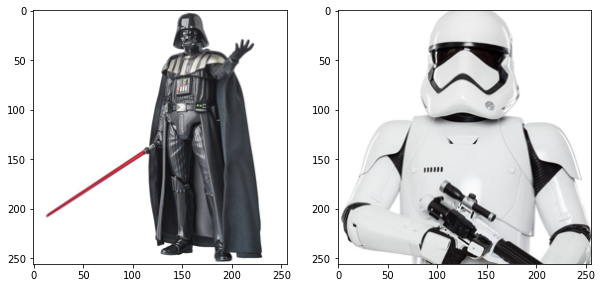

In [55]:
A_data=test_A.__getitem__(3).unsqueeze(0)#(1,3,256,256)
B_data=test_B.__getitem__(10).unsqueeze(0)
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.transpose(A_data[0]*0.5+0.5,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(B_data[0]*0.5+0.5,(1,2,0)))

In [56]:
def plot_train_result(real_img,gen_img,recon_img,epoch,save=True):
    fig,axs=plt.subplots(2,3,figsize=(10,10))
    imgs=[real_img[0].cpu(),gen_img[0].cpu(),recon_img[0].cpu(),
          real_img[1].cpu(),gen_img[1].cpu(),recon_img[1].cpu()]
    for ax,img in zip(axs.flatten(),imgs):
        ax.axis('off')
        img=img.squeeze()
        img=np.transpose((img*0.5+0.5),(1,2,0))
        ax.imshow(img)
    title='Epoch {}'.format(epoch+1)
    fig.text(0.5,0.04,title,ha='center')
    if save:
        plt.savefig('./%d.png'%(epoch+1))
    plt.show()

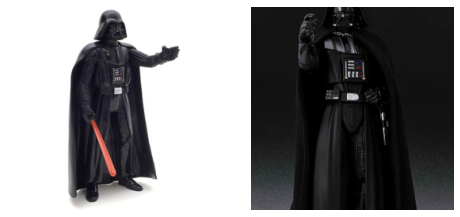

In [57]:
 plt.figure(figsize=(8,8))
 for i in range(2):
     real_batch=next(iter(train_loader_A))
     real_batch=(real_batch+1)/2
     plt.subplot(1,2,i+1)
     plt.axis('off')
     plt.imshow(np.transpose(real_batch[0].to(device).cpu(),(1,2,0)))

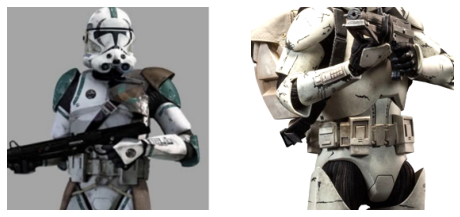

In [58]:
 plt.figure(figsize=(8,8))
 for i in range(2):
     real_b=next(iter(train_loader_B))
     real_b=(real_b+1)/2
     plt.subplot(1,2,i+1)
     plt.axis('off')
     plt.imshow(np.transpose(real_b[0].to(device).cpu(),(1,2,0)))

In [110]:
class ImagePool():
    """
    Данный класс будет использоваться для хранения в буфере ранее сгенерированных изображений
    Буфер позволит апдейтить дискриминатор на наборе изображений, нежели на последнем сгенерированном изображении
    """
    def __init__(self,pool_size):
        self.pool_size=pool_size
        if self.pool_size>0:
            self.num_imgs=0
            self.images=[]
            
    def query(self,images):
        if self.pool_size==0:
            return images
        return_images=[]
        for image in images:
            image=torch.unsqueeze(image.data,0)
            if self.num_imgs<self.pool_size:
                self.num_imgs+=1
                self.images.append(image)
                return_images.append(image)
            else:
                p=random.uniform(0,1)
                if p>0.5: #use previously stored image
                    random_id=random.randint(0,self.pool_size-1)
                    tmp=self.images[random_id].clone()
                    self.images[random_id]=image
                    return_images.append(tmp)
                else: #use current image 
                    return_images.append(image)
        return_images=torch.cat(return_images,0)
        return return_images

In [60]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out,k,s,p,activation='relu',norm=True):
        super(conv_block,self).__init__()
        self.norm=norm
        self.activation=activation
        self.conv=nn.Conv2d(ch_in,ch_out,kernel_size=k,stride=s,padding=p)
        self.bn=nn.InstanceNorm2d(ch_out)
        
    def forward(self,x):
        if self.norm:
            out=self.bn(self.conv(x))
        else:
            out=self.conv(x)
        if self.activation=='relu':
            out=F.relu(out)
        elif self.activation=='lrelu':
            out=F.leaky_relu(out,0.2)
        elif self.activation=='tanh':
            out=torch.tanh(out)
        return out

In [61]:
class deconv_block(nn.Module):
    def __init__(self,ch_in,ch_out,k,s,p,op):
        super(deconv_block,self).__init__()
        self.deconv=nn.ConvTranspose2d(ch_in,ch_out,kernel_size=k,stride=s,padding=p,output_padding=op)
        self.bn=nn.InstanceNorm2d(ch_out)
        
    def forward(self,x):
        out=self.bn(self.deconv(x))
        out=F.relu(out)
        return out

In [62]:
class resnetblock(nn.Module):
    def __init__(self,ch_in,ch_out,k,s,p):
        super(resnetblock,self).__init__()
        self.res=nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch_in,ch_out,kernel_size=k,stride=s,padding=p),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),  #тут проводил эксперименты с испольванием дропаута
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch_out,ch_out,kernel_size=k,stride=s,padding=p),
            nn.InstanceNorm2d(ch_out),
        )
        
    def forward(self,x):
        out=x+self.res(x)
        return out

In [63]:
nc=3
gf=64
df=64

In [64]:
class Generator(nn.Module):
    def __init__(self,num_res=9):
        super(Generator,self).__init__()

        self.pad=nn.ReflectionPad2d(3)
        self.conv1=conv_block(nc,gf,7,1,0)
        self.conv2=conv_block(gf,gf*2,3,2,1)
        self.conv3=conv_block(gf*2,gf*4,3,2,1)

        self.res_blocks=[]
        for i in range(num_res):
            self.res_blocks.append(resnetblock(gf*4,gf*4,3,1,0))
        self.res_blocks=nn.Sequential(*self.res_blocks)

        self.deconv1=deconv_block(gf*4,gf*2,3,2,1,1)
        self.deconv2=deconv_block(gf*2,gf,3,2,1,1)
        self.deconv3=conv_block(gf,nc,7,1,0,activation='tanh',norm=False)
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.normal_(m.weight.data,0.0,0.02)
                nn.init.constant_(m.bias.data,0.0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.normal_(m.weight.data,1.0,0.02)
                nn.init.constant_(m.bias.data,0.0)
        
    def forward(self,x):
        enc1=self.conv1(self.pad(x))
        enc2=self.conv2(enc1)
        enc3=self.conv3(enc2)
        
        res=self.res_blocks(enc3)
        
        dec1=self.deconv1(res)
        dec2=self.deconv2(dec1)
        out=self.deconv3(self.pad(dec2))
        return out
    

In [65]:
model=Generator().to(device)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
        conv_block-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
        conv_block-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
       conv_block-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [66]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1=conv_block(nc,df,4,2,1,activation='lrelu',norm=False)
        self.conv2=conv_block(df,df*2,4,2,1,activation='lrelu')
        self.conv3=conv_block(df*2,df*4,4,2,1,activation='lrelu')
        self.conv4=conv_block(df*4,df*8,4,1,1,activation='lrelu')
        self.conv5=conv_block(df*8,1,4,1,1,activation=None,norm=False)
        self.conv_blocks=nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.normal_(m.weight.data,0.0,0.02)
                nn.init.constant_(m.bias.data,0.0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.normal_(m.weight.data,1.0,0.02)
                nn.init.constant_(m.bias.data,0.0)
                
    def forward(self,x):
        out=self.conv_blocks(x)
        return out          

In [67]:
model=Discriminator().to(device)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2         [-1, 64, 128, 128]           3,136
        conv_block-3         [-1, 64, 128, 128]               0
        conv_block-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]         131,200
            Conv2d-6          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-7          [-1, 128, 64, 64]               0
    InstanceNorm2d-8          [-1, 128, 64, 64]               0
        conv_block-9          [-1, 128, 64, 64]               0
       conv_block-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 32, 32]         524,544
           Conv2d-12          [-1, 256, 32, 32]         524,544
   InstanceNorm2d-13          [-1, 256, 32, 32]               0
   InstanceNorm2d-14          [-1, 256,

In [68]:
G_AB=Generator().to(device)
G_BA=Generator().to(device)
D_A=Discriminator().to(device)
D_B=Discriminator().to(device)

In [69]:
lr_G=0.0002
lr_D=0.0002
G_optimizer=torch.optim.Adam(itertools.chain(G_AB.parameters(),G_BA.parameters()),lr=lr_G,betas=(0.5,0.999))
D_A_optimizer=torch.optim.Adam(D_A.parameters(),lr=lr_D,betas=(0.5,0.999))
D_B_optimizer=torch.optim.Adam(D_B.parameters(),lr=lr_D,betas=(0.5,0.999))
#игрались с шедулерами
#G_shed = torch.optim.lr_scheduler.StepLR(G_optimizer,step_size=20,gamma=0.1)
#DA_shed = torch.optim.lr_scheduler.StepLR(D_A_optimizer,step_size=20,gamma=0.1)
#DB_shed = torch.optim.lr_scheduler.StepLR(D_B_optimizer,step_size=20,gamma=0.1)

In [70]:
MSE_Loss=nn.MSELoss()
L1_Loss=nn.L1Loss()
G_AB_avg_losses=[]
G_BA_avg_losses=[]
D_A_avg_losses=[]
D_B_avg_losses=[]
cycle_A_avg_losses=[]
cycle_B_avg_losses=[]
iters=0

In [71]:
# Generated image pool
num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)

In [72]:
def sample_images():
    G_AB.eval()
    G_BA.eval()
    with torch.no_grad():
        real_A=A_data.to(device)
        fake_B=G_AB(real_A).detach()
        recon_A=G_BA(fake_B).detach()
        
        real_B=B_data.to(device)
        fake_A=G_BA(real_B).detach()
        recon_B=G_AB(fake_A).detach()
        
    plot_train_result([real_A,real_B],[fake_B,fake_A],[recon_A,recon_B],
                           epoch,save=True)

In [73]:
len(train_loader_A)

90

In [74]:
len(train_loader_B)

180

In [ ]:
num_epoch = 130
for epoch in range(num_epoch):
    start=time.time()
    G_AB_losses=[]
    G_BA_losses=[]
    D_A_losses=[]
    D_B_losses=[]
    cycle_A_losses=[]
    cycle_B_losses=[]

    G_AB.train()
    G_BA.train()

    if ((epoch+1)>45) and ((epoch+1)%10==0):
        G_optimizer.param_groups[0]['lr']-=lr_G/10
        D_A_optimizer.param_groups[0]['lr']-=lr_D/10
        D_B_optimizer.param_groups[0]['lr']-=lr_D/10
    
    for i in range(180):
        real_A = next(iter(train_loader_A))
        real_B = next(iter(train_loader_B))
        real_A=real_A.to(device)
        real_B=real_B.to(device)
        #####################################
        #           Train G
        #####################################
        G_optimizer.zero_grad()
        #A-->B
        fake_B=G_AB(real_A)
        D_B_fake_decision=D_B(fake_B)
        G_AB_loss=MSE_Loss(D_B_fake_decision,torch.full(D_B_fake_decision.size(),1,device=device))
        recon_A=G_BA(fake_B)
        cycle_A_loss=L1_Loss(recon_A,real_A)*10
        
        id_A=G_BA(real_A)
        id_A_loss=L1_Loss(id_A,real_A)*10*0.5
        #B-->A
        fake_A=G_BA(real_B)
        D_A_fake_decision=D_A(fake_A)
        G_BA_loss=MSE_Loss(D_A_fake_decision,torch.full(D_A_fake_decision.size(),1,device=device))
        
        recon_B=G_AB(fake_A)
        cycle_B_loss=L1_Loss(recon_B,real_B)*10
        
        id_B=G_AB(real_B)
        id_B_loss=L1_Loss(id_B,real_B)*10*0.5
        #update
        G_loss=G_AB_loss+G_BA_loss+cycle_A_loss+cycle_B_loss+id_A_loss+id_B_loss
        
        G_loss.backward()
        G_optimizer.step()
        
        #####################################
        #           Train D_A
        #####################################
        D_A_optimizer.zero_grad()
        D_A_real_decision=D_A(real_A)
        D_A_real_loss=MSE_Loss(D_A_real_decision,torch.full(D_A_real_decision.size(),1,device=device))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision=D_A(fake_A.detach())
        D_A_fake_loss=MSE_Loss(D_A_fake_decision,torch.full(D_A_fake_decision.size(),0,device=device))
        #update
        D_A_loss=(D_A_real_loss+D_A_fake_loss)*0.5
        
        D_A_loss.backward()
        D_A_optimizer.step()
        
        #####################################
        #           Train D_B
        #####################################
        D_B_optimizer.zero_grad()
        D_B_real_decision=D_B(real_B)
        D_B_real_loss=MSE_Loss(D_B_real_decision,torch.full(D_B_real_decision.size(),1,device=device))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision=D_B(fake_B.detach())
        D_B_fake_loss=MSE_Loss(D_B_fake_decision,torch.full(D_B_fake_decision.size(),0,device=device))
        #update
        D_B_loss=(D_B_real_loss+D_B_fake_loss)*0.5
        
        D_B_loss.backward()
        D_B_optimizer.step()
        
        #sched step
        #G_shed.step()
        #DA_shed.step()
        #DB_shed.step()

        #iters' loss
        G_AB_losses.append(G_AB_loss.item())
        G_BA_losses.append(G_BA_loss.item())
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())
        #print(i)
        if (i%20==0):
            print('Epoch [%d/%d],[%d/%d],D_A_loss:%.4f,D_B_loss:%.4f,G_AB_loss:%.4f,G_BA_loss:%.4f'
             % (epoch+1,100,i,180,D_A_loss.item(),D_B_loss.item(),G_AB_loss.item(),G_BA_loss.item()))
    
    print('Time for one epoch is {} sec'.format(time.time()-start))
    #each epoch loss    
    G_AB_avg_loss=torch.mean(torch.FloatTensor(G_AB_losses))
    G_BA_avg_loss=torch.mean(torch.FloatTensor(G_BA_losses))
    D_A_avg_loss=torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss=torch.mean(torch.FloatTensor(D_B_losses))
    cycle_A_avg_loss=torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss=torch.mean(torch.FloatTensor(cycle_B_losses))
    #all epochs loss list
    G_AB_avg_losses.append(G_AB_avg_loss.item())
    G_BA_avg_losses.append(G_BA_avg_loss.item())
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
    sample_images()

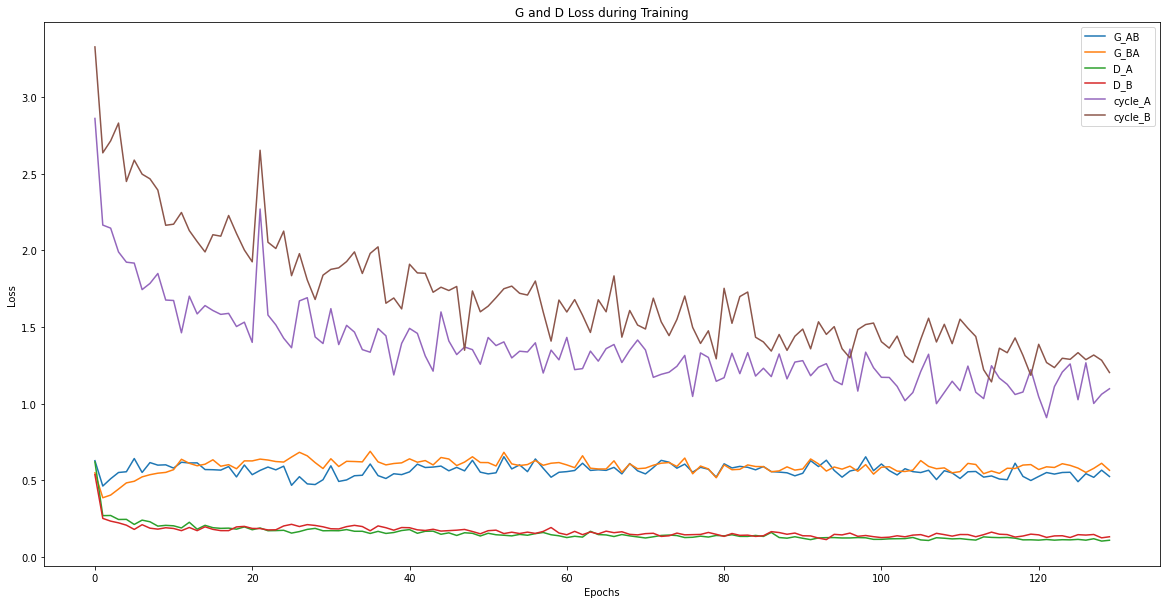

In [78]:
plt.figure(figsize=(20,10))
plt.title('G and D Loss during Training')
plt.plot(G_AB_avg_losses,label='G_AB')
plt.plot(G_BA_avg_losses,label='G_BA')
plt.plot(D_A_avg_losses,label='D_A')
plt.plot(D_B_avg_losses,label='D_B')
plt.plot(cycle_A_avg_losses,label='cycle_A')
plt.plot(cycle_B_avg_losses,label='cycle_B')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
print(np.where(G_AB_avg_losses == np.amin(G_AB_avg_losses)))
print(np.where(G_BA_avg_losses == np.amin(G_BA_avg_losses)))
print(np.where(D_A_avg_losses == np.amin(D_A_avg_losses)))
print(np.where(D_B_avg_losses == np.amin(D_B_avg_losses)))
print(np.where(cycle_A_avg_losses == np.amin(cycle_A_avg_losses)))
print(np.where(cycle_B_avg_losses == np.amin(cycle_B_avg_losses)))

(array([1]),)
(array([1]),)
(array([128]),)
(array([93]),)
(array([121]),)
(array([114]),)


In [82]:
test_loader_A_final=data.DataLoader(test_A,batch_size=1,shuffle=True,num_workers=0)

test_loader_B_final=data.DataLoader(test_B,batch_size=1,shuffle=True,num_workers=0)


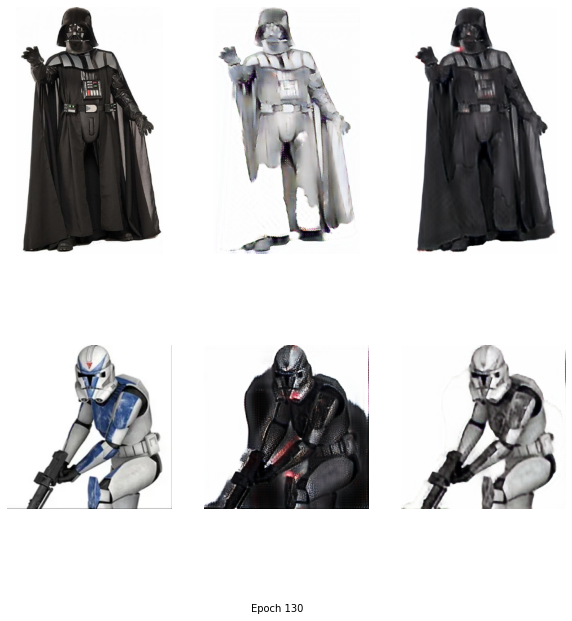

In [106]:
test_img_A = next(iter(test_loader_A_final))
test_img_B = next(iter(test_loader_B_final))
def sample_images1():
    G_AB.eval()
    G_BA.eval()
    with torch.no_grad():
        real_A=test_img_A.to(device)
        fake_B=G_AB(real_A).detach()
        recon_A=G_BA(fake_B).detach()
        
        real_B=test_img_B.to(device)
        fake_A=G_BA(real_B).detach()
        recon_B=G_AB(fake_A).detach()
        
    plot_train_result([real_A,real_B],[fake_B,fake_A],[recon_A,recon_B],
                           epoch,save=True)

sample_images1()

In [109]:
torch.save(G_AB.state_dict(), "/content/drive/My Drive/Colab Notebooks/G_AB.pt")
torch.save(G_BA.state_dict(), "/content/drive/My Drive/Colab Notebooks/G_BA.pt")
torch.save(D_A.state_dict(), "/content/drive/My Drive/Colab Notebooks/D_A.pt")
torch.save(D_B.state_dict(), "/content/drive/My Drive/Colab Notebooks/D_B.pt")

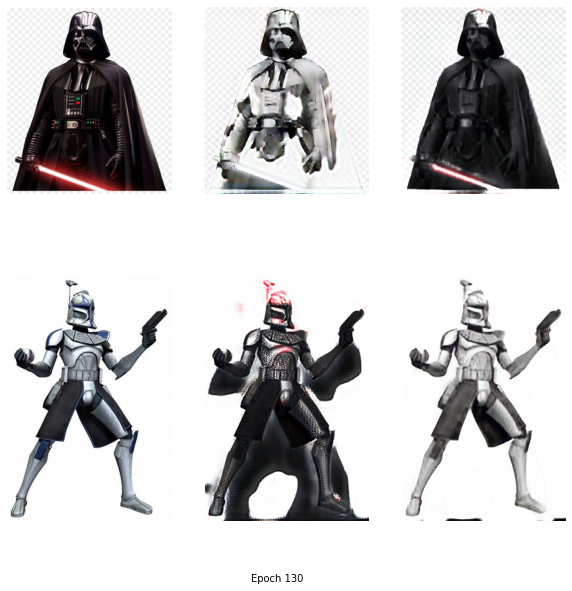

In [116]:
test_img_A = next(iter(test_loader_A_final))
test_img_B = next(iter(test_loader_B_final))
def sample_images2():
    G_AB.eval()
    G_BA.eval()
    with torch.no_grad():
        real_A=test_img_A.to(device)
        fake_B=G_AB(real_A).detach()
        recon_A=G_BA(fake_B).detach()
        
        real_B=test_img_B.to(device)
        fake_A=G_BA(real_B).detach()
        recon_B=G_AB(fake_A).detach()
        
    plot_train_result([real_A,real_B],[fake_B,fake_A],[recon_A,recon_B],
                           epoch,save=True)

sample_images2()

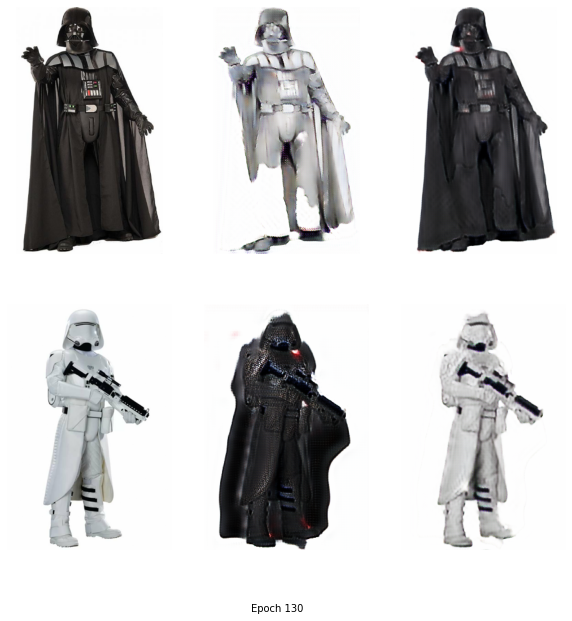

In [119]:
test_img_A = next(iter(test_loader_A_final))
test_img_B = next(iter(test_loader_B_final))
def sample_images3():
    G_AB.eval()
    G_BA.eval()
    with torch.no_grad():
        real_A=test_img_A.to(device)
        fake_B=G_AB(real_A).detach()
        recon_A=G_BA(fake_B).detach()
        
        real_B=test_img_B.to(device)
        fake_A=G_BA(real_B).detach()
        recon_B=G_AB(fake_A).detach()
        
    plot_train_result([real_A,real_B],[fake_B,fake_A],[recon_A,recon_B],
                           epoch,save=True)

sample_images3()